# Classification

Let's train models with the features we have extracted.

In [4]:
import os
os.chdir("../data")

In [5]:
# import dalmatian
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
# from progressbar import ProgressBar  # pip install progressbar2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA


In [6]:
batch_index = pd.read_pickle("working/batch_index.pkl")
feature_df = pd.read_pickle("working/feature_df.pkl")
with open("working/batch_data.pkl", "rb") as f:
    batch_data = pickle.load(f)

## Functions for classification

### Evaluation

In [ ]:
def plot_confusion_matrix(true_values, predicted_values, labels=None, normalize=None, output_dir="output"):
    """Evaluate the performance of a classifier"""

    mx = ConfusionMatrixDisplay.from_predictions(
        true_values,
        predicted_values,
        display_labels=labels,
        normalize="true" if normalize else None,
        include_values=False,
        colorbar=False,
    )
    
    # intercept chart to modify it
    ax = mx.ax_
    mx.plot(
        ax=ax,
        values_format=".0%" if normalize else ".0f",
        colorbar=False,
        cmap=plt.cm.Blues,
    )
    plt.ylabel("True class")
    plt.xlabel("Predicted class")
    plt.colorbar = None
    plt.savefig(f"{output_dir}/confusion_matrix.pdf", bbox_inches="tight")

    # print(f"F1 score: {f1_score(true_values, predicted_values, average='weighted'):.3f}")
    # print(f"Accuracy: {accuracy_score(true_values, predicted_values):.3f}")

In [8]:
def calculate_feature_importances(model, X_test, y_test, classifier, score, feature_columns, id_name, output_path):
    ''' Calculate feature importances and export them to a txt file.
    '''

    # calculate feature importances
    if classifier == "rf":
        importances = model.feature_importances_
    else:
        r = permutation_importance(model, X_test, y_test, n_repeats=10, scoring="f1_weighted", random_state=42)

        # get importance
        importances = r.importances_mean
    
    importance_df = pd.DataFrame(data=importances, index=feature_columns, columns=["importance"])

    # combine importances with feature names
    feature_importances = list(zip(feature_columns, importances))
    feature_importances.sort(key=lambda x: x[1], reverse=True)

    # export feature importances
    with open(f"{output_path}/feature_importances_all.txt", "a") as f:
        f.write(f"Id {id_name}, F1: {score}\n")
        for feature, importance in feature_importances:
            f.write(f"{feature}: {importance:.3f}\n")
        f.write("\n")
    
    return importance_df

In [9]:
def process_results(
    results,
    output_path,
    id_entities,
    feature_columns,
    feature_importance,
):
    importance_df = pd.DataFrame(
        data=np.zeros((len(feature_columns), 1)),
        index=feature_columns,
        columns=["importance"],
    )

    with open(f"{output_path}/metadata.txt", "w") as f:
        f.write(os.path.basename(output_path))
        
    with open(f"{output_path}/features.txt", "w") as f:
        f.write(f"{list(feature_columns)}\n\n")

    true_values = []
    predicted_values = []
    scores = []
    
    for result in results:
        true_values.extend(result["y_test"])
        predicted_values.extend(result["predictions"])
        scores.append(result["score"])

        with open(f"{output_path}/scores.txt", "a") as f:
            f.write(f'{result["id_column"]}: {result["id_entity"]}; F1: {result["score"]:.3f}\n')

        with open(f"{output_path}/confusion_matrices.txt", "a") as f:
            f.write(f'{result["id_column"]}: {result["id_entity"]}\n')
            f.write(f'F1: {result["score"]:.3f}\n')
            f.write(f'{confusion_matrix(result["y_test"], result["predictions"])}\n\n')

        if feature_importance and len(result["importances"]) > 0:
            importance_df["importance"] = (
                importance_df["importance"] + result["importances"]["importance"]
            )
            importance_df[
                f'{result["id_column"][:1]}{str(result["id_entity"]).zfill(2)}'
            ] = result["importances"]  # 'p01' instead of 'p1'
    
        # save models and scalers
        with open(f'{output_path}/model_scaler_{result["id_column"][:1]}{str(result["id_entity"]).zfill(2)}.pkl', "wb") as f:
            pickle.dump((result["model"], result["scaler"]), f)

    with open(f"{output_path}/scores.txt", "a") as f:
        f.write(f"\nMean F1: {np.mean(scores):.3f}\n")
        f.write(f"Standard deviation: {np.std(scores):.3f}\n")
        f.write(f"Min F1: {np.min(scores):.3f}\n")
        f.write(f"Max F1: {np.max(scores):.3f}\n")

    with open(f"{output_path}/confusion_matrices.txt", "a") as f:
        f.write(f"Final confusion matrix\n")
        f.write(
            f"F1: {f1_score(true_values, predicted_values, average='weighted'):.3f}\n"
        )
        f.write(f"{confusion_matrix(true_values, predicted_values)}\n")

    if feature_importance:
        importance_df["importance"] = importance_df["importance"] / len(id_entities)
        importance_df = (
            importance_df.sort_values(by="importance", ascending=False)
            .sort_index(axis=1)
            .round(3)
        )
        importance_df.to_csv(f"{output_path}/feature_importances.csv")
        importance_df.to_pickle(f"{output_path}/feature_importances.pkl")

    pd.DataFrame(
        {
            "true_values": true_values,
            "predicted_values": predicted_values,
        }
    ).to_pickle(f"{output_path}/model_df.pkl")

    print(f"Weighted F1 score: {f1_score(true_values, predicted_values, average='weighted'):.3f}")
    print(f"Accuracy: {accuracy_score(true_values, predicted_values):.3f}\n")

    return true_values, predicted_values, importance_df

### Classification

In [26]:
def datasets_leaving_one_out(
    feature_label_df, id_column, leave_out_id, feature_columns, label_column_name
):
    train_df = feature_label_df[feature_label_df[id_column] != leave_out_id]
    test_df = feature_label_df[feature_label_df[id_column] == leave_out_id]
    X_train = train_df[feature_columns].values
    y_train = train_df[label_column_name].values
    X_test = test_df[feature_columns].values
    y_test = test_df[label_column_name].values

    # scaler = MinMaxScaler().fit(X_train)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, y_train, X_test, y_test, scaler


def train_model(
    feature_label_df,
    id_column,
    leave_out_id,
    feature_columns,
    label_column_name,
    classifier,
    feature_importance,
    output_path,
):
    X_train, y_train, X_test, y_test, scaler = datasets_leaving_one_out(
        feature_label_df, id_column, leave_out_id, feature_columns, label_column_name
    )

    if classifier == "svc": # Support Vector Classifier with probabilities
        model = SVC(class_weight="balanced", probability=True, random_state=42)
    elif classifier == "rf":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
    else:
        raise ValueError("The classifier param should be `svc` or `rf`.")

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = f1_score(y_test, predictions, average="weighted")

    if feature_importance and score > 0.4:
        importances = calculate_feature_importances(
            model,
            X_test,
            y_test,
            classifier,
            score,
            feature_columns,
            leave_out_id,
            output_path,
        )
    else:
        importances = pd.DataFrame()

    return {
        "id_column": id_column,
        "id_entity": leave_out_id,
        "feature_columns": feature_columns,
        "y_test": y_test,
        "predictions": predictions,
        "score": score,
        "importances": importances,
        "model": model,
        "scaler": scaler,
    }

In [11]:
def classify(
    label_column_name: str,
    batch_index: pd.DataFrame,
    sliding_window: tuple,
    classifier: str,
    validation: str,
    feature_columns: list = [],
    feature_importance: bool = False,
    verbose: int = 11,
):
    """Train classifiers using leave-one-out cross validation, exporting results."""

    if validation == "lopo":
        id_column = "pid"
    elif validation == "lodo":
        id_column = "text_id"
    elif validation == "loso":
        id_column = "session_id"
    else:
        raise ValueError("Wrong validation parameter.")

    win_size, step_size = sliding_window

    feature_df = pd.read_pickle(f"working/feature_df.pkl")
    imp_suffix = "_imp" if feature_importance else ""  # calculating feature importance
    
    if len(feature_columns) > 0:
        feature_df = feature_df[feature_columns]
        is_subset = "_subset"
    else:
        feature_columns = feature_df.columns
        is_subset = ""
    
    feature_label_df = pd.merge(
        batch_index[[id_column, label_column_name]],
        feature_df,
        left_index=True,
        right_index=True
    ).dropna()
    feature_label_df[label_column_name] = feature_label_df[label_column_name].astype(int)

    id_entities = list(
        feature_label_df[id_column].unique()
    )  # e.g. [1, ..., 16] for 16 participants or [1, ..., 33] for 33 documents
    
    datetime = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_path = f"output/{datetime}{imp_suffix}_{classifier}_{label_column_name}_{validation}_sw{win_size}-{step_size}{is_subset}"
    os.makedirs(output_path, exist_ok=True)

    # train models in parallel
    results = Parallel(
        n_jobs=-1, verbose=verbose  # verbose > 10, all iterations are reported
    )(
        delayed(train_model)(
            feature_label_df,
            id_column,
            id_entity,
            feature_columns,
            label_column_name,
            classifier,
            feature_importance,
            output_path,
        )
        for id_entity in id_entities
    )
    
    time.sleep(0.1)  # wait for the last iteration to finish

    true_values, predicted_values, importance_df = process_results(
        results,
        output_path,
        id_entities,
        feature_columns,
        feature_importance,
    )

    return true_values, predicted_values, importance_df, output_path

In [12]:
id_column = "session_id"
label_column_name = "solving"
feature_label_df = pd.merge(
        batch_index[[id_column, label_column_name]],
        feature_df,
        left_index=True,
        right_index=True
    ).dropna()
leave_out_id = 0  # session_id
feature_columns = feature_df.columns
sliding_window = (5, 1)
classifier = "svc"
validation = "loso"
feature_importance = True
dir_path = f"output/test"
os.makedirs(dir_path, exist_ok=True)

true_values, predicted_values, importance_df, dir_path = classify(
    label_column_name,
    batch_index,
    sliding_window,
    classifier,
    validation,
    feature_importance=feature_importance,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    6.0s remaining:   23.9s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.0s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    6.0s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.2s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.2s remaining:    1.6s


Weighted F1 score: 0.830
Accuracy: 0.830



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished


In [13]:
importance_df.head(20)

,importance,s00,s01,s02,s03,s04,s05,s06,s07,s08,s09
hand_right_orientation_angular_distance_median,0.038,-0.005,0.110,-0.022,0.037,0.152,0.072,0.052,0.002,0.066,-0.085
head_up_angular_distance_median,0.036,0.021,0.125,-0.003,-0.030,0.036,0.021,0.073,0.060,0.031,0.023
head_position_change_min,0.029,-0.020,0.017,0.010,-0.006,0.039,0.120,0.012,0.032,0.060,0.025
hand_right_position_change_median,0.027,-0.020,0.172,-0.058,0.032,0.067,-0.027,0.051,-0.014,0.050,0.013
head_position_change_median,0.022,-0.022,0.028,-0.014,-0.024,0.019,0.049,0.064,0.070,0.023,0.031
head_position_change_std,0.014,0.000,0.021,-0.009,-0.006,0.028,0.016,0.045,0.015,0.063,-0.032
head_forward_angular_distance_std,0.013,0.000,0.011,0.010,0.000,0.002,0.028,0.011,0.018,0.064,-0.018
fixation_speed_max,0.010,-0.005,0.021,0.021,0.000,0.006,0.016,-0.010,-0.005,0.037,0.021
head_position_change_max,0.009,0.000,0.013,-0.013,-0.036,0.004,0.014,0.039,0.015,0.090,-0.033
fixation_angle_max,0.006,-0.005,0.053,-0.071,-0.092,0.035,0.014,0.048,-0.006,0.039,0.041


In [14]:
# get features with lower variability
importance_sd_df = (
    importance_df[importance_df["importance"] > 0.001]
    .drop("importance", axis=1)
    .std(axis=1)
    .sort_values()
    .index
)

In [17]:
# important_columns = importance_df[importance_df["importance"] > 0.003].index  # mean_based (higher mean importance)
important_columns = importance_sd_df  # sd_based (lower variability)
true_values, predicted_values, importance_df_, dir_path = classify(
    label_column_name,
    batch_index,
    sliding_window,
    classifier,
    validation,
    feature_columns = important_columns
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07579588890075684s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Weighted F1 score: 0.894
Accuracy: 0.895



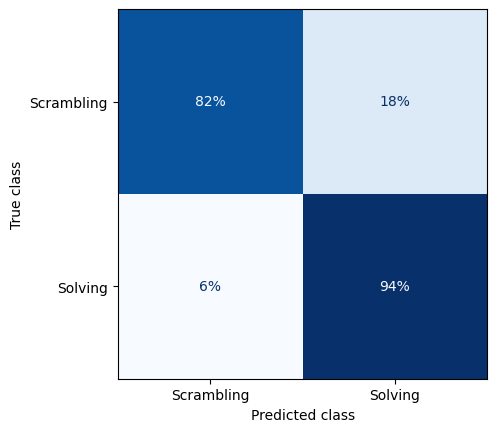

In [18]:
plot_confusion_matrix(
    true_values,
    predicted_values,
    ["Scrambling", "Solving"],
    normalize=True,
    output_dir=dir_path,
)

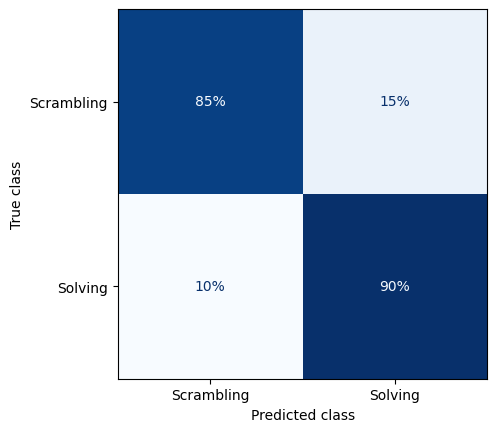

In [20]:
plot_confusion_matrix(
    true_values,
    predicted_values,
    ["Scrambling", "Solving"],
    normalize=True,
    output_dir=dir_path,
)

In [48]:
feature_names = ['fixation_speed_min', 'fixation_distance_min', 'hand_right_radius_std', 'hand_left_position_change_min', 'hand_left_position_change_max', 'fixation_duration_max', 'fixation_speed_max', 'fixation_speed_median', 'hand_left_position_change_std', 'hand_right_orientation_angular_distance_std', 'hand_left_orientation_angular_distance_median', 'head_forward_angular_distance_std', 'fixation_speed_std', 'head_position_change_std', 'fixation_distance_std', 'head_up_angular_distance_min', 'head_position_change_median', 'fixation_distance_max', 'head_position_change_max', 'head_position_change_min', 'fixation_distance_median', 'head_up_angular_distance_median', 'fixation_angle_max', 'hand_right_position_change_median', 'hand_right_orientation_angular_distance_median']
features = [[float(i) for i in """1.12004847e+00 5.24910716e-02 0.00000000e+00 5.43099435e-04
  8.24241542e-02 1.55532300e+00 1.12004847e+00 1.12004847e+00
  1.13781824e-02 5.46155250e-01 9.58131050e-02 1.45146886e-01
  9.69723910e-01 9.78565244e-04 2.76007088e-02 0.00000000e+00
  1.68057386e-03 5.24910716e-02 4.22147977e-03 7.04721571e-05
  5.24910716e-02 6.85088066e-03 6.09465658e-02 3.89150775e-03
  8.61445793e-02""".split()]]
features.append([float(i) for i in """2.10814244e+01  1.80931444e+00 -3.59532851e-01  2.10077188e+00
  -1.18528229e-01  2.42980479e-01  5.77319021e-01  7.35371802e+00
  -1.11728680e-01  2.36980485e+00  3.02357542e+00  9.11767415e+01
   3.82021441e+00  1.81401844e+00 -1.96726488e-02 -1.18814633e+00
   6.90561450e+00 -1.81185645e+00  1.00648405e+00  6.82648995e-02
  -5.02132257e-01  2.75982159e+00 -1.97746955e+00  1.30730961e+00
  -2.22327995e-01""".split()])
features.append([float(i) for i in """1.12004847e+00 5.24910716e-02 0.00000000e+00 5.43099435e-04
  8.24241542e-02 1.55532300e+00 1.12004847e+00 1.12004847e+00
  1.13781824e-02 5.46155250e-01 9.58131050e-02 1.45146886e-01
  9.69723910e-01 9.78565244e-04 2.76007088e-02 0.00000000e+00
  1.68057386e-03 5.24910716e-02 4.22147977e-03 7.04721571e-05
  5.24910716e-02 6.85088066e-03 6.09465658e-02 3.89150775e-03
  8.61445793e-02""".split()])
features.append([float(i) for i in """2.06929027e+01  1.80659781e+00 -3.70393802e-01  2.09519373e+00
  -1.20782620e-01  2.87079052e-01  5.15230039e-01  7.23520509e+00
  -1.13920595e-01  2.32238343e+00  2.67771439e+00  8.97733159e+01
   3.75603840e+00  1.78129028e+00  2.46363784e-02 -1.08471627e+00
   6.83853118e+00 -1.77469528e+00  9.82107611e-01  6.35834873e-02
  -5.19366663e-01  2.59839071e+00 -1.94579396e+00  1.29879969e+00
  -2.44083712e-01""".split()])
features.append([float(i) for i in """1.12004847e+00 5.24910716e-02 0.00000000e+00 5.43099435e-04
  8.24241542e-02 1.55532300e+00 1.12004847e+00 1.12004847e+00
  1.13781824e-02 5.46155250e-01 9.58131050e-02 1.45146886e-01
  9.69723910e-01 9.78565244e-04 2.76007088e-02 0.00000000e+00
  1.68057386e-03 5.24910716e-02 4.22147977e-03 7.04721571e-05
  5.24910716e-02 6.85088066e-03 6.09465658e-02 3.89150775e-03
  8.61445793e-02""".split()])
pd.DataFrame(
    features,
    columns=feature_names
)

,fixation_speed_min,fixation_distance_min,hand_right_radius_std,hand_left_position_change_min,hand_left_position_change_max,fixation_duration_max,fixation_speed_max,fixation_speed_median,hand_left_position_change_std,hand_right_orientation_angular_distance_std,...,head_up_angular_distance_min,head_position_change_median,fixation_distance_max,head_position_change_max,head_position_change_min,fixation_distance_median,head_up_angular_distance_median,fixation_angle_max,hand_right_position_change_median,hand_right_orientation_angular_distance_median
0,1.120048,0.052491,0.000000,0.000543,0.082424,1.555323,1.120048,1.120048,0.011378,0.546155,...,0.000000,0.001681,0.052491,0.004221,0.000070,0.052491,0.006851,0.060947,0.003892,0.086145
1,21.081424,1.809314,-0.359533,2.100772,-0.118528,0.242980,0.577319,7.353718,-0.111729,2.369805,...,-1.188146,6.905615,-1.811856,1.006484,0.068265,-0.502132,2.759822,-1.977470,1.307310,-0.222328
2,1.120048,0.052491,0.000000,0.000543,0.082424,1.555323,1.120048,1.120048,0.011378,0.546155,...,0.000000,0.001681,0.052491,0.004221,0.000070,0.052491,0.006851,0.060947,0.003892,0.086145
3,20.692903,1.806598,-0.370394,2.095194,-0.120783,0.287079,0.515230,7.235205,-0.113921,2.322383,...,-1.084716,6.838531,-1.774695,0.982108,0.063583,-0.519367,2.598391,-1.945794,1.298800,-0.244084
4,1.120048,0.052491,0.000000,0.000543,0.082424,1.555323,1.120048,1.120048,0.011378,0.546155,...,0.000000,0.001681,0.052491,0.004221,0.000070,0.052491,0.006851,0.060947,0.003892,0.086145


In [29]:
feature_df["head_up_angular_distance_std"].describe()

count    543.000000
mean       0.107603
std        0.000129
min        0.107177
25%        0.107504
50%        0.107653
75%        0.107702
max        0.107887
Name: head_up_angular_distance_std, dtype: float64

### Trying regressions

Use model and scaler from session 0 (leave out 0), to test the classification and compare with regression.

In [34]:
glob.glob(f"{dir_path}/model_scaler*.pkl")

['output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset/model_scaler_s05.pkl',
 'output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset/model_scaler_s04.pkl',
 'output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset/model_scaler_s01.pkl',
 'output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset/model_scaler_s09.pkl',
 'output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset/model_scaler_s02.pkl',
 'output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset/model_scaler_s03.pkl',
 'output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset/model_scaler_s07.pkl',
 'output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset/model_scaler_s08.pkl',
 'output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset/model_scaler_s06.pkl',
 'output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset/model_scaler_s00.pkl']

In [45]:
import glob

def load_models(dir_path):
    """Load models from the models directory."""
    models_and_scalers = []
    for model_scaler_path in glob.glob(f"{dir_path}/model_scaler*.pkl"):
        with open(model_scaler_path, "rb") as f:
            if os.path.getsize(model_scaler_path) > 0:
                models_and_scalers.append(pickle.load(f))
    with open(f"{dir_path}/features.txt", "r") as f:
        feature_columns = eval(f.read())  # list of feature columns

    return models_and_scalers, feature_columns

models_and_scalers, feature_columns = load_models("output/2024-10-09_15-04-06_svc_solving_loso_sw5-1_subset")
# models_and_scalers, feature_columns = load_models("output/2024-10-09_12-10-06_svc_solving_loso_sw5-1_subset")

In [46]:
model, scaler = models_and_scalers[0]
pd.DataFrame(scaler.transform(feature_df[feature_columns].dropna().values), columns=feature_columns).describe()

,fixation_speed_min,fixation_distance_min,hand_right_radius_std,hand_left_position_change_min,hand_left_position_change_max,fixation_duration_max,fixation_speed_max,fixation_speed_median,hand_left_position_change_std,hand_right_orientation_angular_distance_std,...,head_up_angular_distance_min,head_position_change_median,fixation_distance_max,head_position_change_max,head_position_change_min,fixation_distance_median,head_up_angular_distance_median,fixation_angle_max,hand_right_position_change_median,hand_right_orientation_angular_distance_median
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,...,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,-0.005644,0.034175,0.006384,0.007270,-0.016826,0.003366,0.019838,0.000199,-0.016484,-0.043004,...,0.011013,-0.103114,-0.004666,-0.018326,-0.081086,-0.019889,-0.108075,-0.023564,-0.074050,-0.169041
std,1.140862,1.005035,1.002765,0.970186,0.931030,0.965728,0.959848,1.048675,0.930971,0.949614,...,0.964044,0.988311,0.953015,0.991053,1.013890,0.984738,0.973847,0.955231,0.978010,1.074621
min,-1.162870,-1.875079,-0.342047,-2.439296,-0.137937,-1.596412,-1.259199,-1.334578,-0.128699,-0.570024,...,-1.108126,-2.184172,-2.645847,-1.275628,-1.579474,-3.166578,-1.389589,-2.711108,-2.278880,-2.444601
25%,-0.597303,-0.671111,-0.342047,-0.628165,-0.136004,-0.713791,-0.744354,-0.616136,-0.127237,-0.490513,...,-1.108126,-0.781544,-0.697052,-0.550942,-0.870548,-0.687630,-0.755161,-0.696006,-0.795785,-0.950810
50%,-0.373976,-0.193870,-0.342047,-0.127826,-0.132126,-0.230272,-0.111886,-0.285231,-0.125167,-0.445947,...,0.098616,-0.256003,-0.092166,-0.311616,-0.217718,-0.050226,-0.421258,-0.217064,-0.223647,-0.252210
75%,0.118249,0.504270,-0.342047,0.749623,-0.125082,0.484773,0.487232,0.257657,-0.120952,-0.335441,...,0.741357,0.437216,0.502211,0.179275,0.511415,0.503504,0.269753,0.522074,0.600110,0.497083
max,9.838481,3.863495,5.705757,2.843807,8.474200,3.381515,3.831044,6.198004,8.719282,4.235670,...,3.545558,3.001813,4.010015,6.921594,5.146793,2.650381,3.674756,3.871414,2.959241,4.308368


In [47]:
pd.DataFrame(scaler.transform([features]), columns=feature_columns)

ValueError: X has 13 features, but StandardScaler is expecting 25 features as input.

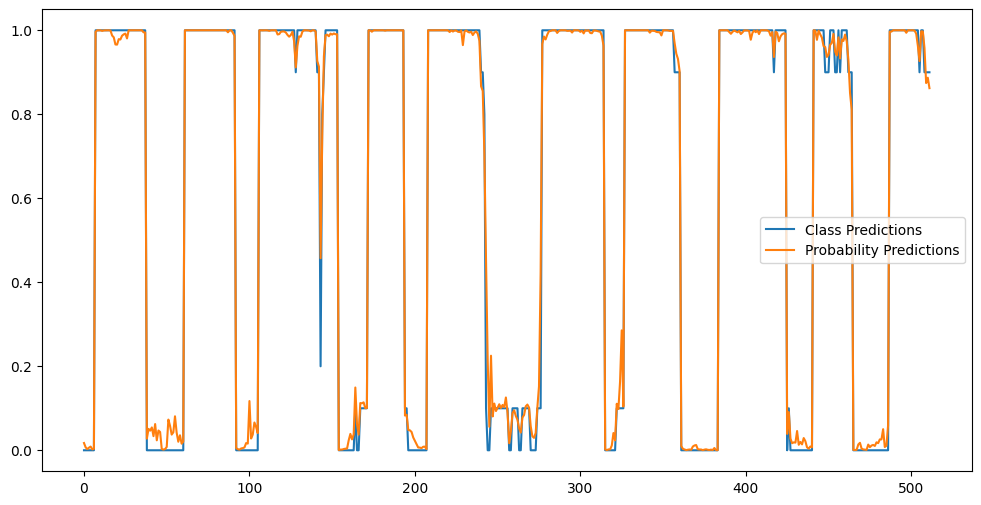

In [63]:
all_predictions_class = []
all_predictions_proba = []
for model, scaler in models_and_scalers:
    X = scaler.transform(feature_df[feature_columns].dropna().values)
    predictions_class = model.predict(X)  # predictions of class
    predictions_proba = model.predict_proba(X)[:, 1]  # probabilities of "solving"
    all_predictions_class.append(predictions_class)
    all_predictions_proba.append(predictions_proba)

# average predictions
predictions_class = np.mean(all_predictions_class, axis=0)
predictions_proba = np.mean(all_predictions_proba, axis=0)

# plot predictions
plt.plot(predictions_class)
plt.plot(predictions_proba)
plt.gcf().set_size_inches(12, 6)
plt.legend(["Class Predictions", "Probability Predictions"])
plt.show()

In [53]:
X = scaler.transform(feature_df[feature_columns].dropna().values)
# get only values from the first column
model.predict_proba(X)[:, 1]

array([8.36920601e-03, 2.77954302e-03, 9.56545961e-04, 1.23231844e-03,
       1.58812267e-03, 5.00307240e-04, 5.53380194e-04, 9.93232255e-01,
       9.99983851e-01, 9.97414562e-01, 9.99997849e-01, 9.96217146e-01,
       9.99989417e-01, 9.99994180e-01, 9.99999614e-01, 9.99999641e-01,
       9.99999448e-01, 9.94441231e-01, 9.96600607e-01, 9.94455212e-01,
       9.94444647e-01, 9.96403794e-01, 9.94451892e-01, 9.95988206e-01,
       9.99984471e-01, 9.99984485e-01, 9.94450706e-01, 9.99999571e-01,
       9.99999818e-01, 9.99999998e-01, 9.99999947e-01, 9.99999890e-01,
       9.99997383e-01, 9.99996408e-01, 9.99991408e-01, 9.99990559e-01,
       9.94446026e-01, 9.92382672e-01, 5.59068615e-03, 8.37932164e-03,
       6.48321236e-03, 8.38245032e-03, 4.31181589e-03, 8.37372989e-03,
       2.17742284e-03, 8.38372351e-03, 8.36112457e-03, 6.29557793e-04,
       4.14025830e-04, 8.89401610e-04, 2.67918161e-03, 1.50901286e-02,
       8.37240223e-03, 8.37933233e-03, 7.63834174e-03, 2.07462706e-02,
      

In [ ]:
feature_label_df = pd.merge(
        batch_index[[id_column, label_column_name]],
        feature_df,
        left_index=True,
        right_index=True
    ).dropna()

In [22]:
feature_df.iloc[0]

fixation_duration_median                 0.471093
fixation_duration_std                    0.339892
fixation_duration_min                    0.046771
fixation_duration_max                    1.085419
fixation_duration_sum_abs_diff           7.214440
                                           ...   
head_up_angular_distance_median          0.008454
head_up_angular_distance_std             0.006205
head_up_angular_distance_min             0.000000
head_up_angular_distance_max             0.028356
head_up_angular_distance_sum_abs_diff    0.476208
Name: 0, Length: 65, dtype: float64

## Run classifiers

In [13]:
id_column = "session_id"
leave_out_id = 0  # session_id
label_column_name = "solving"
feature_label_df = pd.merge(
        batch_index[[id_column, label_column_name]],
        feature_df,
        left_index=True,
        right_index=True
    ).dropna()
feature_columns = feature_df.columns
classifier = "svc"
feature_importance = False
dir_path = f"output/test"
os.makedirs(dir_path, exist_ok=True)
id_entities = list(
        feature_label_df[id_column].unique()
    )  # e.g. [1, ..., 16] for 16 participants or [1, ..., 33] for 33 documents

X_train, y_train, X, X, scaler = datasets_leaving_one_out(
    feature_label_df, id_column, leave_out_id, feature_columns, label_column_name
)
results = train_model(
    feature_label_df,
    id_column,
    leave_out_id,
    feature_columns,
    label_column_name,
    classifier,
    feature_importance,
    dir_path
)
true_values, predicted_values, importance_df = process_results(
    results=[results],
    output_path=dir_path,
    id_entities=id_entities,
    feature_columns=feature_columns,
    feature_importance=feature_importance,
)
plot_confusion_matrix(
    true_values,
    predicted_values,
    ["Scrambling", "Solving"],
    normalize=False,
    output_dir=dir_path,
)

In [7]:
win_size = 5
step_size = 1

In [8]:
feature_name_groups_dict = pickle.load(open('working/feature_name_groups.pkl', 'rb'))
feature_name_groups_dict.keys()

dict_keys(['all', 'gaze', 'heart', 'temp', 'eda', 'participant', 'text'])

In [9]:
pupil_features = ['pupil_diameter_corrected_mean',
 'pupil_diameter_mean',
 'pupil_diameter_std',
 'pupil_diameter_slope',
 'pupil_diameter_d1_mean',
 'pupil_diameter_d1_std']

In [10]:
all_features = feature_name_groups_dict["all"]
gaze_features = [
    'forward_fixations',
    'backward_fixations',
    'forward_duration',
    'backward_duration',
    'omission_rate',
    'pupil_diameter_corrected_mean',
    'pupil_diameter_mean',
    'pupil_diameter_std',
    'pupil_diameter_slope',
    'pupil_diameter_d1_mean',
    'pupil_diameter_d1_std',
    'fixation_duration_mean',
    'fixation_duration_max',
    'fixation_duration_std',
    'saccade_length_mean',
    'saccade_length_max',
    'saccade_length_std',
    'saccade_speed_mean',
    'saccade_speed_max',
    'saccade_speed_std',
    'saccade_angle_mean',
    'saccade_angle_max',
    'saccade_angle_std',
    'lextale_raw',
    'o_difficulty',
]
e4_features = [feature for feature in all_features if feature not in gaze_features]
e4_features

['PPG_Rate_Mean',
 'HRV_MeanNN',
 'HRV_MedianNN',
 'HRV_SDNN',
 'HRV_RMSSD',
 'HRV_SD2',
 'IBI_D1_Mean',
 'IBI_D2_Mean',
 'IBI_D1_Std',
 'IBI_D2_Std',
 'temp_corrected_mean',
 'temp_mean',
 'temp_std',
 'temp_slope',
 'temp_d1_mean',
 'temp_d1_std',
 'eda_tonic_d1_mean',
 'eda_phasic_d1_mean',
 'eda_tonic_d1_std',
 'eda_phasic_d1_std',
 'eda_tonic_d2_mean',
 'eda_phasic_d2_mean',
 'eda_tonic_d2_std',
 'eda_phasic_d2_std',
 'eda_positive_change',
 'eda_min_phasic',
 'eda_max_phasic',
 'eda_mean_phasic',
 'eda_count_phasic']

In [12]:
all_features = feature_name_groups_dict["all"]
exclude = [
    'o_difficulty',
]
selection = [feature for feature in all_features if feature not in exclude]
selection

['forward_fixations',
 'backward_fixations',
 'forward_duration',
 'backward_duration',
 'omission_rate',
 'pupil_diameter_corrected_mean',
 'pupil_diameter_mean',
 'pupil_diameter_std',
 'pupil_diameter_slope',
 'pupil_diameter_d1_mean',
 'pupil_diameter_d1_std',
 'fixation_duration_mean',
 'fixation_duration_max',
 'fixation_duration_std',
 'saccade_length_mean',
 'saccade_length_max',
 'saccade_length_std',
 'saccade_speed_mean',
 'saccade_speed_max',
 'saccade_speed_std',
 'saccade_angle_mean',
 'saccade_angle_max',
 'saccade_angle_std',
 'PPG_Rate_Mean',
 'HRV_MeanNN',
 'HRV_MedianNN',
 'HRV_SDNN',
 'HRV_RMSSD',
 'HRV_SD2',
 'IBI_D1_Mean',
 'IBI_D2_Mean',
 'IBI_D1_Std',
 'IBI_D2_Std',
 'temp_corrected_mean',
 'temp_mean',
 'temp_std',
 'temp_slope',
 'temp_d1_mean',
 'temp_d1_std',
 'eda_tonic_d1_mean',
 'eda_phasic_d1_mean',
 'eda_tonic_d1_std',
 'eda_phasic_d1_std',
 'eda_tonic_d2_mean',
 'eda_phasic_d2_mean',
 'eda_tonic_d2_std',
 'eda_phasic_d2_std',
 'eda_positive_change',
 '

### Run individual models

In [110]:
keep = list({
    'forward_fixations', 'backward_fixations', 'forward_duration',
    'backward_duration', 'pupil_diameter_mean',
    'pupil_diameter_d1_std', 'saccade_length_mean', 'HRV_SDNN',
    'HRV_RMSSD', 'HRV_SD2', 'temp_mean', 'eda_phasic_d2_std',
    'eda_positive_change', 'eda_count_phasic', 'o_difficulty',

    'backward_fixations', 'HRV_MedianNN', 'pupil_diameter_corrected_mean',
    'pupil_diameter_slope', 'temp_std', 'saccade_length_max',
    'temp_corrected_mean', 'backward_duration', 'saccade_angle_std',
    'lextale_raw', 'temp_mean', 'o_difficulty', 'pupil_diameter_mean',
    'omission_rate', 'forward_fixations'
})


In [108]:
len(keep)

27

In [122]:
all_features = feature_name_groups_dict["all"]
angle_features = [
    'saccade_angle_mean',
    'saccade_angle_max',
    'saccade_angle_std',
]
keep = [feature for feature in all_features if feature not in angle_features]
keep

['forward_fixations',
 'backward_fixations',
 'forward_duration',
 'backward_duration',
 'omission_rate',
 'pupil_diameter_corrected_mean',
 'pupil_diameter_mean',
 'pupil_diameter_std',
 'pupil_diameter_slope',
 'pupil_diameter_d1_mean',
 'pupil_diameter_d1_std',
 'fixation_duration_mean',
 'fixation_duration_max',
 'fixation_duration_std',
 'saccade_length_mean',
 'saccade_length_max',
 'saccade_length_std',
 'saccade_speed_mean',
 'saccade_speed_max',
 'saccade_speed_std',
 'PPG_Rate_Mean',
 'HRV_MeanNN',
 'HRV_MedianNN',
 'HRV_SDNN',
 'HRV_RMSSD',
 'HRV_SD2',
 'IBI_D1_Mean',
 'IBI_D2_Mean',
 'IBI_D1_Std',
 'IBI_D2_Std',
 'temp_corrected_mean',
 'temp_mean',
 'temp_std',
 'temp_slope',
 'temp_d1_mean',
 'temp_d1_std',
 'eda_tonic_d1_mean',
 'eda_phasic_d1_mean',
 'eda_tonic_d1_std',
 'eda_phasic_d1_std',
 'eda_tonic_d2_mean',
 'eda_phasic_d2_mean',
 'eda_tonic_d2_std',
 'eda_phasic_d2_std',
 'eda_positive_change',
 'eda_min_phasic',
 'eda_max_phasic',
 'eda_mean_phasic',
 'eda_count

In [13]:
true_values, predicted_values, importance_df, dir_path = classify(
    "s_difficulty",
    trial_df,
    sliding_window=(win_size, step_size),
    classifier="svc",
    validation="lopo",
    shifted=False,
    feature_columns=[],
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   59.0s remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:  1.0min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  1.0min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:  1.1min remaining:   42.1s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  1.5min remaining:   38.2s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:  1.5min remaining:   22.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.5min remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


Weighted F1 score: 0.434
Accuracy: 0.434



>> Exported a matrix to ./out.pdf


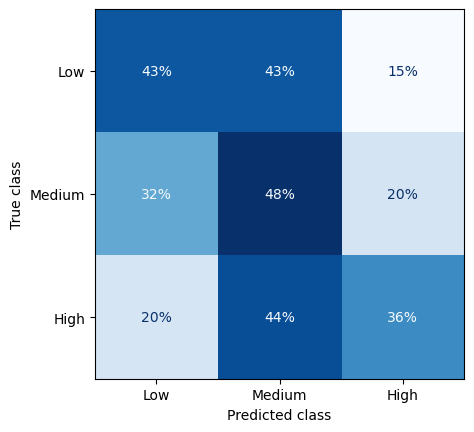

In [14]:
plot_confusion_matrix(
    true_values,
    predicted_values,
    ["Low", "Medium", "High"],
    normalize=True,
    output_dir=dir_path,
)

In [123]:
true_values, predicted_values, importance_df, dir_path = classify(
    "s_difficulty",
    trial_df,
    sliding_window=(win_size, step_size),
    classifier="svc",
    validation="lopo",
    shifted=False,
    feature_columns=e4_features,
    feature_importance=True,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   31.1s remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   31.9s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   32.8s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   51.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   53.4s remaining:   53.4s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:  2.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  3.9min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:  4.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  5.0min remaining:   33.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.5min finished


Weighted F1 score: 0.424
Accuracy: 0.425



>> Exported a matrix to ./out.pdf


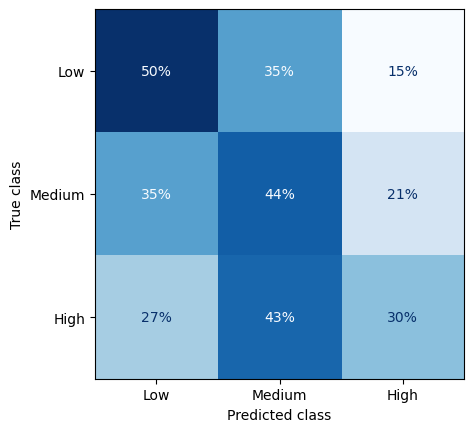

In [119]:
plot_confusion_matrix(
    true_values,
    predicted_values,
    ["Low", "Medium", "High"],
    normalize=True,
    output_dir=dir_path,
)

In [120]:
true_values, predicted_values, importance_df, dir_path = classify(
    "s_difficulty",
    trial_df,
    sliding_window=(win_size, step_size),
    classifier="svc",
    validation="lodo",
    shifted=False,
    feature_columns=e4_features,
    feature_importance=True,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   45.1s remaining:  6.8min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:  3.8min remaining: 15.2min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  4.2min remaining:  9.9min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:  5.1min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  5.3min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:  5.6min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  6.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:  6.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  7.3min remaining:   48.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.2min finished


Weighted F1 score: 0.473
Accuracy: 0.473



>> Exported a matrix to ./out.pdf


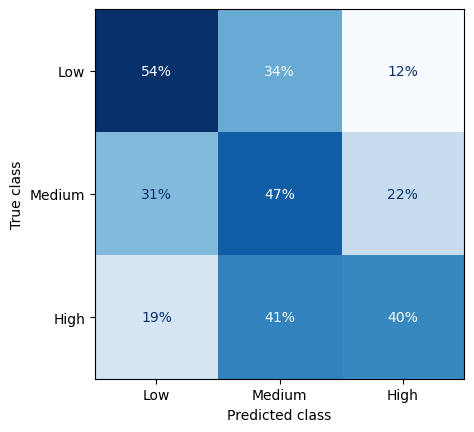

In [121]:
plot_confusion_matrix(
    true_values,
    predicted_values,
    ["Low", "Medium", "High"],
    normalize=True,
    output_dir=dir_path,
)

In [80]:
best_features = [ # final features after removing highly correlated features and some trial and error
    "forward_duration",
    "backward_fixations",
    # "pupil_diameter_corrected_mean",
    "pupil_diameter_mean",
    "PPG_Rate_Mean", # "hr_mean"
    "temp_corrected_mean",
    "eda_positive_change",
    "eda_count_phasic",
    "lextale_raw",
    "o_difficulty",
]

In [81]:
# lopo
# 427 440 rf; 429 429 svc; standard
# 426 437 rf; 404 406 svc; minmax

# lodo
# 482 491 rf; 457 459 svc; standard
# 485 493 rf; 438 445 svc; minmax
true_values, predicted_values, importance_df, dir_path = classify(
        "s_difficulty",
        trial_df,
        sliding_window=(win_size, step_size),
        classifier="rf",
        validation="lodo",
        shifted=True,
        feature_columns=best_features,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   10.1s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   10.5s remaining:   42.4s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   10.8s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   11.4s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   12.1s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   13.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   14.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   15.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   15.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.3s finished


Weighted F1 score: 0.494
Accuracy: 0.501



>> Exported a matrix to ./out.pdf


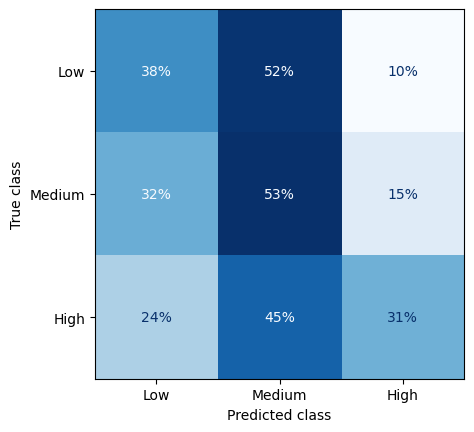

In [15]:
plot_confusion_matrix(
    true_values,
    predicted_values,
    ["Low", "Medium", "High"],
    normalize=True,
    output_dir=dir_path,
)

In [68]:
# lopo
# 411 451 rf; 434 434 svc; standard

# lodo
# 498 521 rf; 521 521 svc; standard
true_values, predicted_values, importance_df, dir_path = classify(
        "s_difficulty",
        trial_df,
        sliding_window=(win_size, step_size),
        classifier="svc",
        validation="lodo",
        shifted=False,
        # feature_columns=best_features,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   35.9s remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   37.1s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   37.9s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   38.4s remaining:   57.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   38.9s remaining:   38.9s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   39.2s remaining:   26.1s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   51.8s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   52.5s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   52.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   52.9s finished



Weighted F1 score: 0.521
Accuracy: 0.521



>> Exported a matrix to ./out.pdf


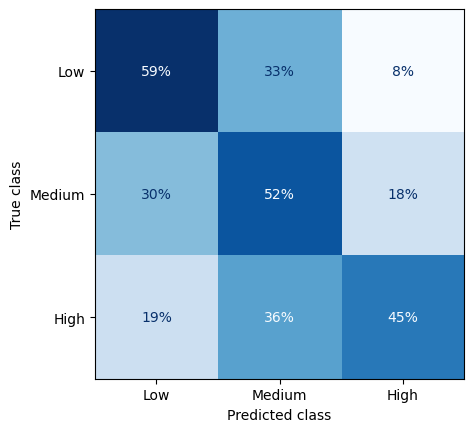

In [69]:
plot_confusion_matrix(
    true_values,
    predicted_values,
    ["Low", "Medium", "High"],
    normalize=True,
    output_dir=dir_path,
)

### Create results table

In [49]:
feature_name_groups_dict = pickle.load(open('working/feature_name_groups.pkl', 'rb'))

common = feature_name_groups_dict["participant"] + feature_name_groups_dict["text"]  # not sensors
feature_name_groups = [
    ("All", feature_name_groups_dict["all"]),
    ("Gaze data", feature_name_groups_dict["gaze"] + common),
    ("Cardiac data", feature_name_groups_dict["heart"] + common),
    ("EDA", feature_name_groups_dict["eda"] + common),
    ("Temperature", feature_name_groups_dict["temp"] + common),
]
feature_df_raw = pd.read_pickle(f'working/feature_df_{win_size}-{step_size}_raw.pkl')
feature_df_sh = pd.read_pickle(f'working/feature_df_{win_size}-{step_size}_sh.pkl')
feature_df_list = [feature_df_raw, feature_df_sh]
df_types = ["Raw", "Shifted"]
classifiers = ["SVC", "RF"]
result_table_columns = [('SVC', 'Raw'), ('SVC', 'Shifted'), ('RF', 'Raw'), ('RF', 'Shifted')]

In [56]:
# all features
for validation in ["lopo", "lodo"]:
    print(f"Validation: {validation}")
    results = pd.DataFrame(columns=pd.MultiIndex.from_tuples(result_table_columns))
    for classifier in classifiers:
        # print(f"Classifier: {classifier}")
        for df_type, feature_df in zip(df_types, feature_df_list):
            # print(f"Dataframe type: {df_type}")
            if df_type == "Raw":
                shifted = False
            elif df_type == "Shifted":
                shifted = True

            for feature_group, feature_names in feature_name_groups:
                true_values, predicted_values, importance_df, dir_path = classify(
                    "s_difficulty",
                    trial_df,
                    sliding_window=(win_size, step_size),
                    classifier=classifier.lower(),
                    validation=validation,
                    shifted=shifted,
                    feature_columns=feature_names,
                    verbose=0
                )
                results.loc[feature_group, (classifier, df_type)] = f1_score(true_values, predicted_values, average='weighted')
    results.to_pickle(f"output/results_{validation}_all.pkl")
    print(results)

Validation: lopo


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   39.0s remaining:  5.9min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   39.5s remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   40.7s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   41.0s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   41.6s remaining:   41.6s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   42.3s remaining:   28.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   55.7s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   56.8s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   56.9s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   57.1s finished



Weighted F1 score: 0.434
Accuracy: 0.434



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   20.0s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   20.4s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   20.4s remaining:   47.8s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   20.7s remaining:   31.0s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   20.9s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   21.2s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   30.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   31.3s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   31.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.5s finished



Weighted F1 score: 0.417
Accuracy: 0.416



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   19.3s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   19.7s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   20.3s remaining:   47.4s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   20.5s remaining:   30.8s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   21.2s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   21.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   32.8s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   33.4s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   33.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   34.0s finished



Weighted F1 score: 0.383
Accuracy: 0.385



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   21.2s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   21.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   21.7s remaining:   50.8s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   22.0s remaining:   33.0s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   22.0s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   22.4s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   33.9s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   35.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   35.4s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.5s finished



Weighted F1 score: 0.393
Accuracy: 0.402



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   15.5s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   15.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   16.0s remaining:   37.4s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   16.4s remaining:   24.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   16.8s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   17.0s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   25.3s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   26.6s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   26.7s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.8s finished



Weighted F1 score: 0.397
Accuracy: 0.394



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   37.3s remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   37.7s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   38.6s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   38.8s remaining:   58.2s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   39.6s remaining:   39.6s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   40.1s remaining:   26.7s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   53.4s remaining:   22.8s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   54.3s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   54.6s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   54.8s finished



Weighted F1 score: 0.433
Accuracy: 0.433



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   19.4s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   20.0s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   20.1s remaining:   47.0s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   20.4s remaining:   30.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   20.6s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   20.9s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   30.2s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   30.5s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   30.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.1s finished



Weighted F1 score: 0.411
Accuracy: 0.409



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   18.4s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   19.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   19.5s remaining:   45.7s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   19.8s remaining:   29.8s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   20.4s remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   21.0s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   31.8s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   32.6s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   32.9s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.1s finished



Weighted F1 score: 0.394
Accuracy: 0.396



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   21.0s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   21.5s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   21.8s remaining:   50.9s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   22.2s remaining:   33.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   22.7s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   23.4s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   34.9s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   35.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   35.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   36.0s finished



Weighted F1 score: 0.394
Accuracy: 0.402



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   14.8s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   15.5s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   15.8s remaining:   37.0s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   15.8s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   16.3s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   16.4s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   25.5s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   26.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   26.5s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.7s finished



Weighted F1 score: 0.380
Accuracy: 0.378



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   29.8s remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   30.7s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   31.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   31.7s remaining:   47.6s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   32.5s remaining:   32.5s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   36.6s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   45.1s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   45.7s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   45.9s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   46.0s finished



Weighted F1 score: 0.411
Accuracy: 0.451



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   21.5s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   21.7s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   22.0s remaining:   51.4s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   22.6s remaining:   34.0s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   23.7s remaining:   23.7s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   24.9s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   31.9s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   32.6s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   32.7s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   32.8s finished



Weighted F1 score: 0.409
Accuracy: 0.441



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   13.6s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   14.2s remaining:   56.9s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   14.6s remaining:   34.3s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   16.0s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   17.9s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   19.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   20.5s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   20.6s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   20.8s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.9s finished



Weighted F1 score: 0.424
Accuracy: 0.436



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   11.2s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   11.6s remaining:   46.6s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   12.0s remaining:   28.0s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   12.3s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   13.0s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   14.0s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   15.6s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   16.9s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   17.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.2s finished



Weighted F1 score: 0.385
Accuracy: 0.402



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:    9.4s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:    9.7s remaining:   39.2s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   10.0s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   11.6s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   13.5s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   13.9s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   14.2s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   14.4s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   14.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.7s finished



Weighted F1 score: 0.410
Accuracy: 0.424



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   31.2s remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   31.4s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   31.6s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   31.8s remaining:   47.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   32.1s remaining:   32.1s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   32.4s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   46.9s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   47.1s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   47.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   47.3s finished



Weighted F1 score: 0.400
Accuracy: 0.435



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   21.6s remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   21.9s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   22.1s remaining:   51.8s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   22.4s remaining:   33.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   23.0s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   23.9s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   32.3s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   32.7s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   32.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   32.9s finished



Weighted F1 score: 0.400
Accuracy: 0.429



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   14.1s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   14.6s remaining:   58.7s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   15.9s remaining:   37.3s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   17.2s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   18.1s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   18.9s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   19.9s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   21.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   21.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.6s finished



Weighted F1 score: 0.397
Accuracy: 0.411



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   11.7s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   12.2s remaining:   49.3s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   13.1s remaining:   30.6s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   14.1s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   15.1s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   15.7s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   16.4s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   16.9s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   17.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.3s finished



Weighted F1 score: 0.406
Accuracy: 0.417



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:    9.2s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:    9.5s remaining:   38.5s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   10.3s remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   11.1s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   12.0s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   13.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   13.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   13.6s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   13.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.8s finished



Weighted F1 score: 0.403
Accuracy: 0.422

                   SVC                  RF          
                   Raw   Shifted       Raw   Shifted
All           0.434317  0.433143  0.411251  0.399742
Gaze data     0.416909  0.410675  0.409001  0.400431
Cardiac data  0.383423  0.394427  0.423952  0.396996
EDA           0.393306  0.393744  0.385436  0.405573
Temperature   0.397167  0.380401  0.409682  0.403211
Validation: lodo


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   35.9s remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   37.5s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   38.3s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   38.6s remaining:   58.0s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   39.4s remaining:   39.4s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   39.9s remaining:   26.6s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   52.7s remaining:   22.5s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   53.0s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   53.3s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   53.4s finished



Weighted F1 score: 0.521
Accuracy: 0.521



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   19.7s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   19.9s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   20.0s remaining:   46.8s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   20.1s remaining:   30.1s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   20.1s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   20.2s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   29.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   29.4s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   29.6s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.8s finished



Weighted F1 score: 0.478
Accuracy: 0.477



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   19.7s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   20.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   20.4s remaining:   47.6s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   20.7s remaining:   31.2s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   20.9s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   21.4s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   32.0s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   32.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   33.0s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.2s finished



Weighted F1 score: 0.420
Accuracy: 0.418



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   20.5s remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   21.0s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   21.4s remaining:   50.1s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   21.5s remaining:   32.4s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   21.8s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   22.1s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   34.2s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   34.8s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   35.0s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.2s finished



Weighted F1 score: 0.393
Accuracy: 0.403



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   15.1s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   15.6s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   16.0s remaining:   37.5s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   16.4s remaining:   24.6s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   16.5s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   16.7s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   25.8s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   26.4s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   26.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.2s finished



Weighted F1 score: 0.452
Accuracy: 0.452



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   35.6s remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   36.1s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   36.9s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   37.1s remaining:   55.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   38.0s remaining:   38.0s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   38.3s remaining:   25.5s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   51.5s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   52.9s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   53.1s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   53.2s finished



Weighted F1 score: 0.514
Accuracy: 0.515



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   19.2s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   19.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   19.7s remaining:   46.1s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   20.0s remaining:   30.0s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   20.3s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   20.4s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   30.2s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   30.6s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   30.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.0s finished



Weighted F1 score: 0.487
Accuracy: 0.487



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   20.9s remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   21.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   22.3s remaining:   52.2s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   22.8s remaining:   34.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   23.1s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   23.7s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   34.0s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   35.6s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   36.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   36.4s finished



Weighted F1 score: 0.415
Accuracy: 0.415



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   23.5s remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   24.1s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   24.4s remaining:   57.0s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   25.0s remaining:   37.5s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   25.1s remaining:   25.1s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   26.0s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   37.3s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   38.5s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   38.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.1s finished



Weighted F1 score: 0.387
Accuracy: 0.397



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   17.8s remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   18.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   18.2s remaining:   42.7s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   18.5s remaining:   27.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   18.6s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   19.1s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   28.5s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   28.9s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   29.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.3s finished



Weighted F1 score: 0.429
Accuracy: 0.432



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   31.5s remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   31.6s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   31.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   32.1s remaining:   48.2s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   32.5s remaining:   32.5s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   33.2s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   46.9s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   47.3s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   47.4s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   47.5s finished



Weighted F1 score: 0.498
Accuracy: 0.521



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   21.8s remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   22.2s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   22.6s remaining:   52.9s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   23.1s remaining:   34.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   23.5s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   24.0s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   32.8s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   33.2s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   33.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.5s finished



Weighted F1 score: 0.480
Accuracy: 0.498



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   15.2s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   15.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   16.2s remaining:   37.9s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   17.4s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   18.7s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   20.3s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   21.1s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   22.0s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   22.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.4s finished



Weighted F1 score: 0.503
Accuracy: 0.514



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   11.5s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   12.0s remaining:   48.5s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   12.5s remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   13.9s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   15.1s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   15.9s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   16.5s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   17.1s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   17.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.4s finished



Weighted F1 score: 0.470
Accuracy: 0.484



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:    9.3s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:    9.6s remaining:   38.7s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   10.3s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   10.8s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   12.1s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   13.5s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   13.8s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   14.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   14.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.2s finished



Weighted F1 score: 0.478
Accuracy: 0.485



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   30.7s remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   31.0s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   31.1s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   31.3s remaining:   47.0s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   31.7s remaining:   31.7s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   32.1s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   45.5s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   46.1s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   46.1s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   46.2s finished



Weighted F1 score: 0.492
Accuracy: 0.515



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   21.5s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   21.7s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   22.2s remaining:   51.9s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   22.9s remaining:   34.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   23.4s remaining:   23.4s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   24.1s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   31.6s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   32.2s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   32.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   32.3s finished



Weighted F1 score: 0.486
Accuracy: 0.502



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   14.0s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   14.4s remaining:   57.8s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   14.9s remaining:   34.9s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   15.6s remaining:   23.4s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   16.7s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   18.1s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   20.3s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   20.6s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   20.8s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.9s finished



Weighted F1 score: 0.473
Accuracy: 0.487



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   11.1s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:   11.5s remaining:   46.4s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   11.9s remaining:   27.9s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   13.0s remaining:   19.5s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   14.1s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   15.5s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   15.8s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   16.3s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   16.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.6s finished



Weighted F1 score: 0.467
Accuracy: 0.480



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:    8.9s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:    9.4s remaining:   37.8s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   10.0s remaining:   23.4s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   10.8s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   11.7s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   12.3s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:   12.9s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed:   13.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   13.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.4s finished



Weighted F1 score: 0.459
Accuracy: 0.469

                   SVC                  RF          
                   Raw   Shifted       Raw   Shifted
All           0.520593  0.514179  0.498485  0.491688
Gaze data     0.477792  0.486522   0.48011  0.486125
Cardiac data   0.42003  0.414593  0.502766  0.473404
EDA           0.392696  0.387293  0.470162  0.466946
Temperature   0.452144  0.429259  0.478272  0.458893


In [77]:
text_features = ['lextale_raw', 'o_difficulty']

# best 25% features for each data source
for validation in ["lopo", "lodo"]:
    print(f"Validation: {validation}")
    results = pd.DataFrame(columns=pd.MultiIndex.from_tuples(result_table_columns))
    for classifier in classifiers:
        # print(f"Classifier: {classifier}")
        for df_type, feature_df in zip(df_types, feature_df_list):
            # print(f"Dataframe type: {df_type}")
            if df_type == "Raw":
                shifted = False
            elif df_type == "Shifted":
                shifted = True

            for feature_group, feature_names in feature_name_groups:
                true_values, predicted_values, importance_df, dir_path = classify(
                    "s_difficulty",
                    trial_df,
                    sliding_window=(win_size, step_size),
                    classifier='svc',
                    validation=validation,
                    shifted=shifted,
                    feature_columns=feature_names[:-2],
                    verbose=0
                )
                subset_length = round(len(feature_names[:-2])*0.25)
                subset = list(importance_df.index[:subset_length]) + text_features
                print(subset)
                true_values, predicted_values, importance_df, dir_path = classify(
                    "s_difficulty",
                    trial_df,
                    sliding_window=(win_size, step_size),
                    classifier=classifier.lower(),
                    validation=validation,
                    shifted=shifted,
                    feature_columns=subset,
                    verbose=0
                )
                results.loc[feature_group, (classifier, df_type)] = f1_score(true_values, predicted_values, average='weighted')
    results.to_pickle(f"output/results_{validation}_subset25.pkl")
    results = results.apply(pd.to_numeric, errors='coerce')
    print(results.round(3))

Validation: lopo
Weighted F1 score: 0.434
Accuracy: 0.434

['forward_fixations', 'backward_fixations', 'forward_duration', 'backward_duration', 'omission_rate', 'pupil_diameter_corrected_mean', 'pupil_diameter_mean', 'pupil_diameter_std', 'pupil_diameter_slope', 'pupil_diameter_d1_mean', 'pupil_diameter_d1_std', 'fixation_duration_mean', 'fixation_duration_max', 'fixation_duration_std']
Weighted F1 score: 0.356
Accuracy: 0.352

Weighted F1 score: 0.417
Accuracy: 0.416

['forward_fixations', 'backward_fixations', 'forward_duration', 'backward_duration', 'omission_rate', 'pupil_diameter_corrected_mean']
Weighted F1 score: 0.395
Accuracy: 0.395

Weighted F1 score: 0.383
Accuracy: 0.385

['PPG_Rate_Mean', 'HRV_MeanNN', 'HRV_MedianNN']
Weighted F1 score: 0.339
Accuracy: 0.327

Weighted F1 score: 0.393
Accuracy: 0.402

['eda_tonic_d1_mean', 'eda_phasic_d1_mean', 'eda_tonic_d1_std', 'eda_phasic_d1_std']
Weighted F1 score: 0.226
Accuracy: 0.321

Weighted F1 score: 0.397
Accuracy: 0.394

['temp